In [8]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import pickle

# TDA libraries
from ripser import ripser
from persim import plot_diagrams
import gudhi as gd
from scipy.spatial.distance import squareform


In [9]:
with open('reddit_graph.pkl', 'rb') as f:
    G = pickle.load(f)
print(f"Loaded graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


Loaded graph with 35776 nodes and 137821 edges.


In [10]:
def print_graph_summary(G):
    print("Graph Summary")
    print("-------------")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    avg_in_degree = np.mean([d for n, d in G.in_degree()])
    avg_out_degree = np.mean([d for n, d in G.out_degree()])
    print(f"Average in-degree: {avg_in_degree:.2f}")
    print(f"Average out-degree: {avg_out_degree:.2f}")
    print(f"Density: {nx.density(G):.6f}")
    weights = [edata['weight'] for _, _, edata in G.edges(data=True)]
    print(f"Edge weight stats: min={np.min(weights)}, max={np.max(weights)}, mean={np.mean(weights):.2f}, median={np.median(weights)}")
    top_in = sorted(G.in_degree(), key=lambda x: x[1], reverse=True)[:5]
    print("Top 5 nodes by in-degree:")
    for node, deg in top_in:
        print(f"  {node}: {deg}")
    top_out = sorted(G.out_degree(), key=lambda x: x[1], reverse=True)[:5]
    print("Top 5 nodes by out-degree:")
    for node, deg in top_out:
        print(f"  {node}: {deg}")

print_graph_summary(G)


Graph Summary
-------------
Number of nodes: 35776
Number of edges: 137821
Average in-degree: 3.85
Average out-degree: 3.85
Density: 0.000108
Edge weight stats: min=1, max=548, mean=2.08, median=1.0
Top 5 nodes by in-degree:
  askreddit: 2161
  iama: 1646
  pics: 953
  videos: 879
  todayilearned: 816
Top 5 nodes by out-degree:
  subredditdrama: 1350
  copypasta: 636
  drama: 600
  subredditoftheday: 559
  outoftheloop: 507


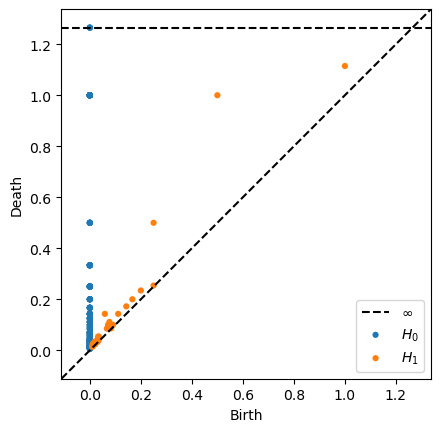

In [11]:
def compute_distance_matrix(subG, nodes):
    n = len(nodes)
    distance_matrix = np.full((n, n), np.inf)
    for i, u in enumerate(nodes):
        lengths = nx.single_source_dijkstra_path_length(subG, u, weight=lambda u, v, d: 1/d['weight'])
        for j, v in enumerate(nodes):
            if v in lengths:
                distance_matrix[i, j] = lengths[v]
    np.fill_diagonal(distance_matrix, 0)
    for i in range(n):
        for j in range(i+1, n):
            d = min(distance_matrix[i, j], distance_matrix[j, i])
            distance_matrix[i, j] = d
            distance_matrix[j, i] = d
    return distance_matrix

nodes = list(G.nodes)[:200]
subG = G.subgraph(nodes)
distance_matrix = compute_distance_matrix(subG, nodes)
diagrams = ripser(distance_matrix, distance_matrix=True)['dgms']
plot_diagrams(diagrams, show=True)


In [12]:
def print_top_persistent_H1(diagrams, k=3):
    H1 = diagrams[1]
    persistences = H1[:,1] - H1[:,0]
    outlier_indices = np.argsort(persistences)[-k:]
    print("Top persistent H1 features (birth, death, persistence):")
    for i, idx in enumerate(outlier_indices):
        print(f"{i+1}: Birth={H1[idx,0]:.3f}, Death={H1[idx,1]:.3f}, Persistence={persistences[idx]:.3f}")

print_top_persistent_H1(diagrams, k=3)


Top persistent H1 features (birth, death, persistence):
1: Birth=1.000, Death=1.115, Persistence=0.115
2: Birth=0.250, Death=0.500, Persistence=0.250
3: Birth=0.500, Death=1.000, Persistence=0.500


In [13]:
def get_representative_cycle(distance_matrix, nodes, diagrams):
    H1 = diagrams[1]
    persistences = H1[:,1] - H1[:,0]
    most_persistent_idx = np.argmax(persistences)
    birth_value = H1[most_persistent_idx, 0]
    threshold = birth_value + 1e-8
    adjacency = (distance_matrix <= threshold).astype(int)
    G_thresh = nx.Graph()
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if adjacency[i, j]:
                G_thresh.add_edge(nodes[i], nodes[j])
    cycles = nx.cycle_basis(G_thresh)
    if cycles:
        print("Nodes (subreddits) in a representative cycle for the most persistent H1 feature:")
        print(cycles[0])
    else:
        print("No cycles found at this threshold.")

get_representative_cycle(distance_matrix, nodes, diagrams)


Nodes (subreddits) in a representative cycle for the most persistent H1 feature:
['leagueoflegends', 'pornfree', 'dogecoin']


In [14]:
def gudhi_persistence(subG, nodes):
    distance_matrix = compute_distance_matrix(subG, nodes)
    finite_distances = distance_matrix[np.isfinite(distance_matrix)]
    max_dist = np.max(finite_distances)
    large_value = 2 * max_dist
    distance_matrix[~np.isfinite(distance_matrix)] = large_value
    rips_complex = gd.RipsComplex(distance_matrix=distance_matrix, max_edge_length=max_dist)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    diag = simplex_tree.persistence(homology_coeff_field=2, persistence_dim_max=True)
    H1_loops = [(i, p) for i, p in enumerate(diag) if p[0] == 1 and p[1][1] < float('inf')]
    print("Top H1 features (loops):")
    for idx, (dim, (birth, death)) in H1_loops:
        print(f"Feature {idx}: Birth={birth:.3f}, Death={death:.3f}, Persistence={death-birth:.3f}")

gudhi_persistence(subG, nodes)


Top H1 features (loops):
Feature 1077969: Birth=0.500, Death=1.000, Persistence=0.500
Feature 1077970: Birth=0.250, Death=0.500, Persistence=0.250
Feature 1077971: Birth=1.000, Death=1.115, Persistence=0.115
Feature 1077972: Birth=0.059, Death=0.143, Persistence=0.084
Feature 1077973: Birth=0.200, Death=0.234, Persistence=0.034
Feature 1077974: Birth=0.077, Death=0.111, Persistence=0.034
Feature 1077975: Birth=0.167, Death=0.200, Persistence=0.033
Feature 1077976: Birth=0.111, Death=0.143, Persistence=0.032
Feature 1077977: Birth=0.143, Death=0.172, Persistence=0.029
Feature 1077978: Birth=0.071, Death=0.100, Persistence=0.029
Feature 1077979: Birth=0.032, Death=0.054, Persistence=0.022
Feature 1077980: Birth=0.071, Death=0.091, Persistence=0.019
Feature 1077981: Birth=0.067, Death=0.085, Persistence=0.018
Feature 1077982: Birth=0.036, Death=0.054, Persistence=0.018
Feature 1077983: Birth=0.019, Death=0.034, Persistence=0.015
Feature 1077984: Birth=0.031, Death=0.045, Persistence=0.014

In [15]:
def find_isolated_cliques(G):
    G_undirected = G.to_undirected()
    cliques = list(nx.find_cliques(G_undirected))
    components = list(nx.connected_components(G_undirected))
    isolated_cliques = []
    for clique in cliques:
        clique_set = set(clique)
        if clique_set in components and len(clique) > 1:
            isolated_cliques.append(clique)
    if isolated_cliques:
        print("Isolated maximal cliques (tightly connected groups not connected to anything else):")
        for idx, clique in enumerate(isolated_cliques, 1):
            print(f"Clique {idx} (size {len(clique)}): {clique}")
    else:
        print("No isolated maximal cliques found.")

find_isolated_cliques(G)


Isolated maximal cliques (tightly connected groups not connected to anything else):
Clique 1 (size 2): ['asscredit', 'surrealhumor']
Clique 2 (size 2): ['tibersandbox', 'mewtwo928']
Clique 3 (size 2): ['arts', 'durian']
Clique 4 (size 2): ['tbtl', 'reallybigshow']
Clique 5 (size 2): ['bunsenlabs', 'crunchbangplusplus']
Clique 6 (size 2): ['powerball', 'powerballpool']
Clique 7 (size 2): ['idleheroes', 'idleheroesps']
Clique 8 (size 2): ['newportnews', 'cnu']
Clique 9 (size 2): ['whycoin', 'cryptocurrencies']
Clique 10 (size 2): ['6661766f7269746563', 'solving_66617']
Clique 11 (size 2): ['fiorerpg', 'fiorerpgcharacterbios']
Clique 12 (size 2): ['doterra', 'essentialoils']
Clique 13 (size 2): ['apidura', 'ultouring']
Clique 14 (size 2): ['takecareofmyplant', 'backcamera']
Clique 15 (size 2): ['asianladyboy', 'ladyboys']
Clique 16 (size 2): ['catsofthewild', 'burntpretzel']
Clique 17 (size 2): ['modarachnocapitalists', 'modelrinationalists']
Clique 18 (size 2): ['circumcisions', 'circumc

In [16]:
import numpy as np

def clique_strength(clique, G):
    """Compute the average edge weight within a clique."""
    weights = []
    for i in range(len(clique)):
        for j in range(i+1, len(clique)):
            u, v = clique[i], clique[j]
            if G.has_edge(u, v):
                w = G[u][v].get('weight', 1)
                weights.append(w)
    return np.mean(weights) if weights else 0

def top_cliques_by_strength(G, top_n=10, min_size=3):
    """Find top cliques by average edge weight."""
    G_undirected = G.to_undirected()
    cliques = list(nx.find_cliques(G_undirected))
    clique_strengths = []
    for clique in cliques:
        if len(clique) >= min_size:
            strength = clique_strength(clique, G_undirected)
            clique_strengths.append((clique, strength))
    top_cliques = sorted(clique_strengths, key=lambda x: x[1], reverse=True)[:top_n]
    print(f"Top {top_n} cliques by average edge weight:")
    for idx, (clique, strength) in enumerate(top_cliques, 1):
        print(f"{idx}. Size: {len(clique)}, Strength: {strength:.2f}, Subreddits: {clique}")

top_cliques_by_strength(G, top_n=10, min_size=3)


Top 10 cliques by average edge weight:
1. Size: 3, Strength: 122.67, Subreddits: ['circloljerk', 'leagueoflegends', 'summonerschool']
2. Size: 3, Strength: 84.33, Subreddits: ['gameshare', 'mushroomkingdom', 'gamesale']
3. Size: 3, Strength: 83.00, Subreddits: ['circloljerk', 'leagueoflegends', 'clg']
4. Size: 3, Strength: 82.67, Subreddits: ['wttnvidia', 'gamesale', 'mushroomkingdom']
5. Size: 3, Strength: 82.00, Subreddits: ['boardgameexchange', 'mushroomkingdom', 'gamesale']
6. Size: 3, Strength: 81.67, Subreddits: ['joahfx', 'gamesale', 'mushroomkingdom']
7. Size: 3, Strength: 81.67, Subreddits: ['yardsale', 'gamesale', 'mushroomkingdom']
8. Size: 3, Strength: 79.00, Subreddits: ['lux', 'summonerschool', 'leagueoflegends']
9. Size: 3, Strength: 78.33, Subreddits: ['summonerschool', 'leagueoflegends', 'kindred']
10. Size: 3, Strength: 77.33, Subreddits: ['summonerschool', 'leagueoflegends', 'jhinmains']


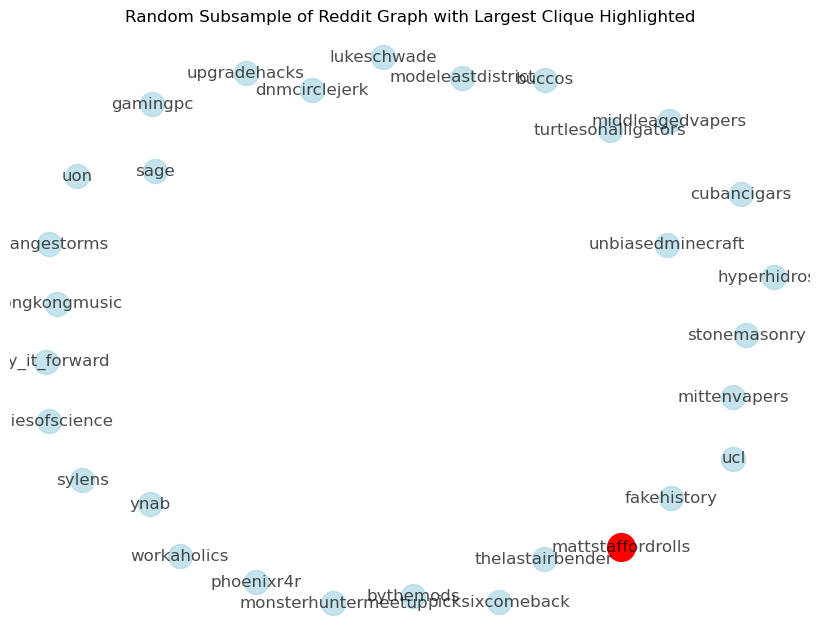

In [17]:
import matplotlib.pyplot as plt
import random

def visualize_largest_clique(G, sample_size=30):
    sample_nodes = random.sample(list(G.nodes), sample_size)
    subG = G.subgraph(sample_nodes).to_undirected()
    cliques = list(nx.find_cliques(subG))
    largest_clique = max(cliques, key=len) if cliques else []
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(subG, seed=42)
    nx.draw(subG, pos, node_color='lightblue', with_labels=True, node_size=300, edge_color='gray', alpha=0.7)
    if largest_clique:
        nx.draw_networkx_nodes(subG, pos, nodelist=largest_clique, node_color='red', node_size=400)
        nx.draw_networkx_edges(
            subG, pos,
            edgelist=[(u, v) for u in largest_clique for v in largest_clique if u != v and subG.has_edge(u, v)],
            edge_color='red', width=2
        )
    plt.title("Random Subsample of Reddit Graph with Largest Clique Highlighted")
    plt.axis('off')
    plt.show()

visualize_largest_clique(G, sample_size=30)


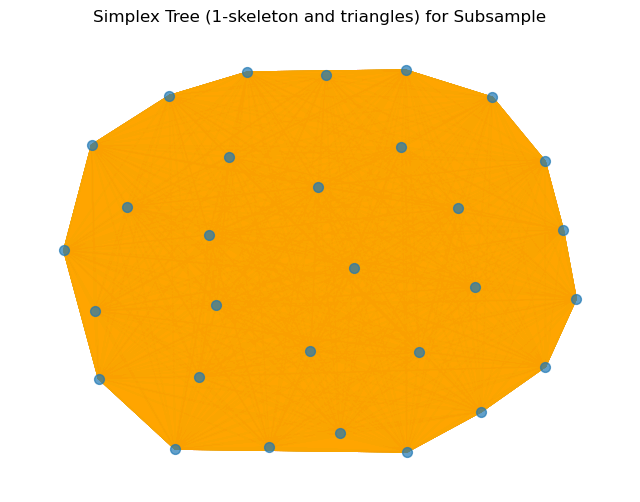

In [18]:
import gudhi as gd

def visualize_simplices(G, sample_size=30):
    nodes_sub = random.sample(list(G.nodes), sample_size)
    subG = G.subgraph(nodes_sub).to_undirected()
    n = len(nodes_sub)
    distance_matrix = np.full((n, n), np.inf)
    for i, u in enumerate(nodes_sub):
        lengths = nx.single_source_dijkstra_path_length(subG, u, weight=lambda u, v, d: 1/d.get('weight', 1))
        for j, v in enumerate(nodes_sub):
            if v in lengths:
                distance_matrix[i, j] = lengths[v]
    np.fill_diagonal(distance_matrix, 0)
    for i in range(n):
        for j in range(i+1, n):
            d = min(distance_matrix[i, j], distance_matrix[j, i])
            distance_matrix[i, j] = d
            distance_matrix[j, i] = d
    finite_distances = distance_matrix[np.isfinite(distance_matrix)]
    max_dist = np.max(finite_distances)
    large_value = 2 * max_dist
    distance_matrix[~np.isfinite(distance_matrix)] = large_value
    rips_complex = gd.RipsComplex(distance_matrix=distance_matrix, max_edge_length=max_dist)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    edges, triangles = [], []
    for simplex, filtration in simplex_tree.get_filtration():
        if len(simplex) == 2:
            edges.append(tuple(simplex))
        elif len(simplex) == 3:
            triangles.append(tuple(simplex))
    edges_named = [(nodes_sub[i], nodes_sub[j]) for i, j in edges]
    triangles_named = [(nodes_sub[i], nodes_sub[j], nodes_sub[k]) for i, j, k in triangles]
    G_simplex = nx.Graph()
    G_simplex.add_edges_from(edges_named)
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G_simplex, seed=42)
    nx.draw_networkx_edges(G_simplex, pos, alpha=0.3)
    nx.draw_networkx_nodes(G_simplex, pos, node_size=50, alpha=0.7)
    for triangle in triangles_named:
        pts = [pos[n] for n in triangle]
        polygon = plt.Polygon(pts, closed=True, fill=True, color='orange', alpha=0.2)
        plt.gca().add_patch(polygon)
    plt.title("Simplex Tree (1-skeleton and triangles) for Subsample")
    plt.axis('off')
    plt.show()

visualize_simplices(G, sample_size=30)


Number of simplices by dimension:
Dimension 0: 100
Dimension 1: 4950
Dimension 2: 161700


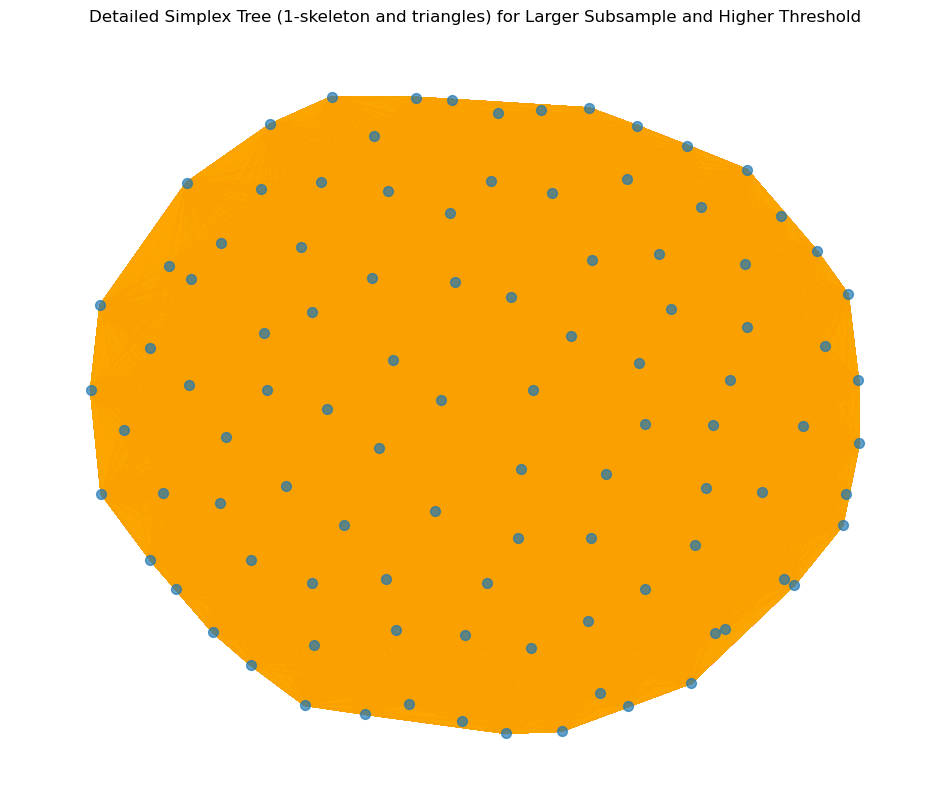

In [19]:
def simplex_counts_large_subsample(G, sample_size=100):
    nodes_sub = random.sample(list(G.nodes), sample_size)
    subG = G.subgraph(nodes_sub).to_undirected()
    n = len(nodes_sub)
    distance_matrix = np.full((n, n), np.inf)
    for i, u in enumerate(nodes_sub):
        lengths = nx.single_source_dijkstra_path_length(subG, u, weight=lambda u, v, d: 1/d.get('weight', 1))
        for j, v in enumerate(nodes_sub):
            if v in lengths:
                distance_matrix[i, j] = lengths[v]
    np.fill_diagonal(distance_matrix, 0)
    for i in range(n):
        for j in range(i+1, n):
            d = min(distance_matrix[i, j], distance_matrix[j, i])
            distance_matrix[i, j] = d
            distance_matrix[j, i] = d
    finite_distances = distance_matrix[np.isfinite(distance_matrix)]
    max_dist = np.max(finite_distances)
    large_value = 2 * max_dist
    distance_matrix[~np.isfinite(distance_matrix)] = large_value
    rips_complex = gd.RipsComplex(distance_matrix=distance_matrix, max_edge_length=10 * max_dist)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    simplex_counts = {}
    for simplex, filtration in simplex_tree.get_filtration():
        dim = len(simplex) - 1
        simplex_counts[dim] = simplex_counts.get(dim, 0) + 1
    print("Number of simplices by dimension:")
    for dim in sorted(simplex_counts):
        print(f"Dimension {dim}: {simplex_counts[dim]}")
    # Visualization
    edges, triangles = [], []
    for simplex, filtration in simplex_tree.get_filtration():
        if len(simplex) == 2:
            edges.append(tuple(simplex))
        elif len(simplex) == 3:
            triangles.append(tuple(simplex))
    edges_named = [(nodes_sub[i], nodes_sub[j]) for i, j in edges]
    triangles_named = [(nodes_sub[i], nodes_sub[j], nodes_sub[k]) for i, j, k in triangles]
    G_simplex = nx.Graph()
    G_simplex.add_edges_from(edges_named)
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G_simplex, seed=42)
    nx.draw_networkx_edges(G_simplex, pos, alpha=0.3)
    nx.draw_networkx_nodes(G_simplex, pos, node_size=50, alpha=0.7)
    for triangle in triangles_named:
        pts = [pos[n] for n in triangle]
        polygon = plt.Polygon(pts, closed=True, fill=True, color='orange', alpha=0.2)
        plt.gca().add_patch(polygon)
    plt.title("Detailed Simplex Tree (1-skeleton and triangles) for Larger Subsample and Higher Threshold")
    plt.axis('off')
    plt.show()

simplex_counts_large_subsample(G, sample_size=100)


In [20]:
import networkx as nx
import numpy as np

def analyze_cliques(
    G,
    min_size=3,
    max_size=None,
    top_n=10,
    show_isolated=True,
    show_strength=True,
    show_in_out=True,
    show_diff=True
):
    """
    Perform various clique analyses on a (directed) graph G.
    
    Parameters:
        G: networkx.DiGraph or Graph
        min_size: minimum clique size to consider
        max_size: maximum clique size to consider (None for no upper bound)
        top_n: number of top results to print for each analysis
        show_isolated: whether to print isolated cliques
        show_strength: whether to print top cliques by average internal edge weight
        show_in_out: whether to print cliques with many incoming and few outgoing edges
        show_diff: whether to print cliques by greatest difference (in - out)
    """
    G_undirected = G.to_undirected()
    cliques = list(nx.find_cliques(G_undirected))
    if max_size is not None:
        cliques = [c for c in cliques if min_size <= len(c) <= max_size]
    else:
        cliques = [c for c in cliques if len(c) >= min_size]
    
    # 1. Isolated cliques
    if show_isolated:
        components = list(nx.connected_components(G_undirected))
        isolated_cliques = [clique for clique in cliques if set(clique) in components and len(clique) > 1]
        print("Isolated maximal cliques (tightly connected groups not connected to anything else):")
        if isolated_cliques:
            for idx, clique in enumerate(isolated_cliques, 1):
                print(f"  {idx}. Size: {len(clique)}, Nodes: {clique}")
        else:
            print("  None found.")
        print()
    
    # 2. Clique strength (average internal edge weight)
    def clique_strength(clique, G):
        weights = []
        for i in range(len(clique)):
            for j in range(i+1, len(clique)):
                u, v = clique[i], clique[j]
                if G.has_edge(u, v):
                    w = G[u][v].get('weight', 1)
                    weights.append(w)
        return np.mean(weights) if weights else 0

    if show_strength:
        clique_strengths = [(clique, clique_strength(clique, G_undirected)) for clique in cliques]
        top_cliques = sorted(clique_strengths, key=lambda x: x[1], reverse=True)[:top_n]
        print(f"Top {top_n} cliques by average internal edge weight:")
        for idx, (clique, strength) in enumerate(top_cliques, 1):
            print(f"  {idx}. Size: {len(clique)}, Strength: {strength:.2f}, Nodes: {clique}")
        print()
    
    # 3. In/out edge analysis
    results = []
    for clique in cliques:
        in_count = 0
        out_count = 0
        for node in clique:
            in_edges = [src for src in G.predecessors(node) if src not in clique]
            in_count += len(in_edges)
            out_edges = [tgt for tgt in G.successors(node) if tgt not in clique]
            out_count += len(out_edges)
        results.append({
            'clique': clique,
            'in_count': in_count,
            'out_count': out_count,
            'diff': in_count - out_count,
            'size': len(clique)
        })
    
    if show_in_out:
        sorted_in = sorted(results, key=lambda x: (-x['in_count'], x['out_count']))
        print(f"Top {top_n} cliques with many incoming and few outgoing edges:")
        for entry in sorted_in[:top_n]:
            print(f"  Size: {entry['size']}, In: {entry['in_count']}, Out: {entry['out_count']}, Nodes: {entry['clique']}")
        print()
        sorted_insulated = sorted(results, key=lambda x: (x['in_count'], x['out_count']))
        print(f"Top {top_n} most insulated cliques (fewest incoming, then fewest outgoing edges):")
        for entry in sorted_insulated[:top_n]:
            print(f"  Size: {entry['size']}, In: {entry['in_count']}, Out: {entry['out_count']}, Nodes: {entry['clique']}")
        print()
    
    if show_diff:
        sorted_diff = sorted(results, key=lambda x: x['diff'], reverse=True)
        print(f"Top {top_n} cliques by greatest difference between incoming and outgoing edges (in - out):")
        for entry in sorted_diff[:top_n]:
            print(f"  Size: {entry['size']}, In: {entry['in_count']}, Out: {entry['out_count']}, Diff: {entry['diff']}, Nodes: {entry['clique']}")
        print()

# Example usage:
#analyze_cliques(G, min_size=3, max_size=5, top_n=10)


In [21]:
analyze_cliques(G, min_size=3, max_size=5, top_n=10)

Isolated maximal cliques (tightly connected groups not connected to anything else):
  1. Size: 3, Nodes: ['bitcoinwhores', 'wallpapertiles', 'candofundraising']
  2. Size: 3, Nodes: ['dmvtokers', 'mdents', 'delawarent']

Top 10 cliques by average internal edge weight:
  1. Size: 3, Strength: 122.67, Nodes: ['circloljerk', 'leagueoflegends', 'summonerschool']
  2. Size: 3, Strength: 84.33, Nodes: ['gameshare', 'mushroomkingdom', 'gamesale']
  3. Size: 3, Strength: 83.00, Nodes: ['circloljerk', 'leagueoflegends', 'clg']
  4. Size: 3, Strength: 82.67, Nodes: ['wttnvidia', 'gamesale', 'mushroomkingdom']
  5. Size: 3, Strength: 82.00, Nodes: ['boardgameexchange', 'mushroomkingdom', 'gamesale']
  6. Size: 3, Strength: 81.67, Nodes: ['joahfx', 'gamesale', 'mushroomkingdom']
  7. Size: 3, Strength: 81.67, Nodes: ['yardsale', 'gamesale', 'mushroomkingdom']
  8. Size: 3, Strength: 79.00, Nodes: ['lux', 'summonerschool', 'leagueoflegends']
  9. Size: 3, Strength: 78.33, Nodes: ['summonerschool', 

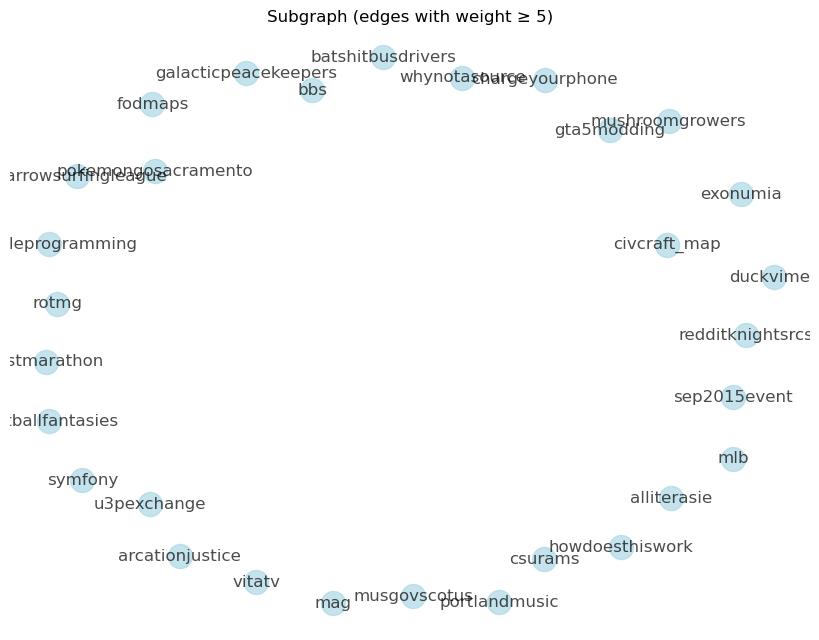

In [22]:
import matplotlib.pyplot as plt
import networkx as nx
import random

def visualize_weighted_subgraph(G, sample_size=30, weight_threshold=5):
    # Randomly sample nodes
    sample_nodes = random.sample(list(G.nodes), sample_size)
    subG = G.subgraph(sample_nodes)
    # Create a new undirected graph with only edges above threshold
    filteredG = nx.Graph()
    filteredG.add_nodes_from(subG.nodes)
    for u, v, d in subG.edges(data=True):
        if d.get('weight', 1) >= weight_threshold:
            filteredG.add_edge(u, v, weight=d['weight'])
    # Draw with labels
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(filteredG, seed=42)
    nx.draw(filteredG, pos, node_color='lightblue', with_labels=True, node_size=300, edge_color='gray', alpha=0.7)
    plt.title(f"Subgraph (edges with weight ≥ {weight_threshold})")
    plt.axis('off')
    plt.show()

visualize_weighted_subgraph(G, sample_size=30, weight_threshold=5)


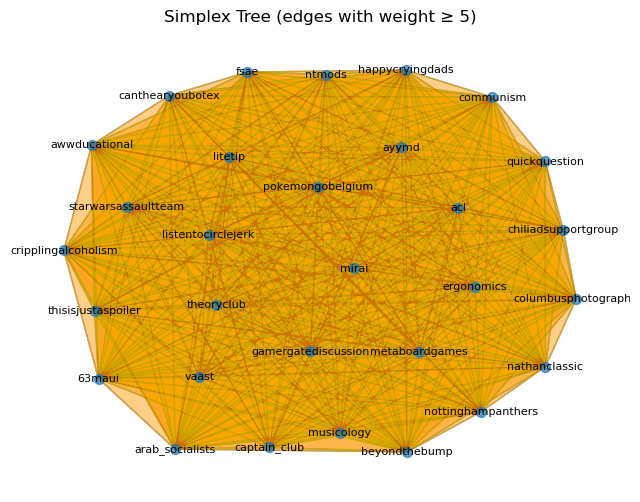

In [71]:
import gudhi as gd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random

def visualize_simplex_tree_with_threshold(G, sample_size=30, weight_threshold=5):
    # Sample nodes and build filtered subgraph
    nodes_sub = random.sample(list(G.nodes), sample_size)
    subG = G.subgraph(nodes_sub)
    filteredG = nx.Graph()
    filteredG.add_nodes_from(subG.nodes)
    for u, v, d in subG.edges(data=True):
        if d.get('weight', 1) >= weight_threshold:
            filteredG.add_edge(u, v, weight=d['weight'])
    # Build distance matrix for Gudhi
    n = len(nodes_sub)
    distance_matrix = np.full((n, n), np.inf)
    for i, u in enumerate(nodes_sub):
        lengths = nx.single_source_dijkstra_path_length(filteredG, u, weight=lambda u, v, d: 1/d.get('weight', 1))
        for j, v in enumerate(nodes_sub):
            if v in lengths:
                distance_matrix[i, j] = lengths[v]
    np.fill_diagonal(distance_matrix, 0)
    for i in range(n):
        for j in range(i+1, n):
            d = min(distance_matrix[i, j], distance_matrix[j, i])
            distance_matrix[i, j] = d
            distance_matrix[j, i] = d
    finite_distances = distance_matrix[np.isfinite(distance_matrix)]
    if len(finite_distances) == 0:
        print("No finite distances in the filtered subgraph. Try lowering the threshold.")
        return
    max_dist = np.max(finite_distances)
    large_value = 2 * max_dist
    distance_matrix[~np.isfinite(distance_matrix)] = large_value
    # Gudhi Rips complex
    rips_complex = gd.RipsComplex(distance_matrix=distance_matrix, max_edge_length=max_dist)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    # Extract edges and triangles
    edges = []
    triangles = []
    for simplex, filtration in simplex_tree.get_filtration():
        if len(simplex) == 2:
            edges.append(tuple(simplex))
        elif len(simplex) == 3:
            triangles.append(tuple(simplex))
    # Map indices to subreddit names
    edges_named = [(nodes_sub[i], nodes_sub[j]) for i, j in edges]
    triangles_named = [(nodes_sub[i], nodes_sub[j], nodes_sub[k]) for i, j, k in triangles]
    # Visualize
    G_simplex = nx.Graph()
    G_simplex.add_edges_from(edges_named)
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G_simplex, seed=42)
    nx.draw_networkx_edges(G_simplex, pos, alpha=0.3)
    nx.draw_networkx_nodes(G_simplex, pos, node_size=50, alpha=0.7)
    nx.draw_networkx_labels(G_simplex, pos, font_size=8)  # <-- Node labels
    for triangle in triangles_named:
        pts = [pos[n] for n in triangle]
        polygon = plt.Polygon(pts, closed=True, fill=True, color='orange', alpha=0.02)
        plt.gca().add_patch(polygon)
    plt.title(f"Simplex Tree (edges with weight ≥ {weight_threshold})")
    plt.axis('off')
    plt.show()

visualize_simplex_tree_with_threshold(G, sample_size=30, weight_threshold=5)


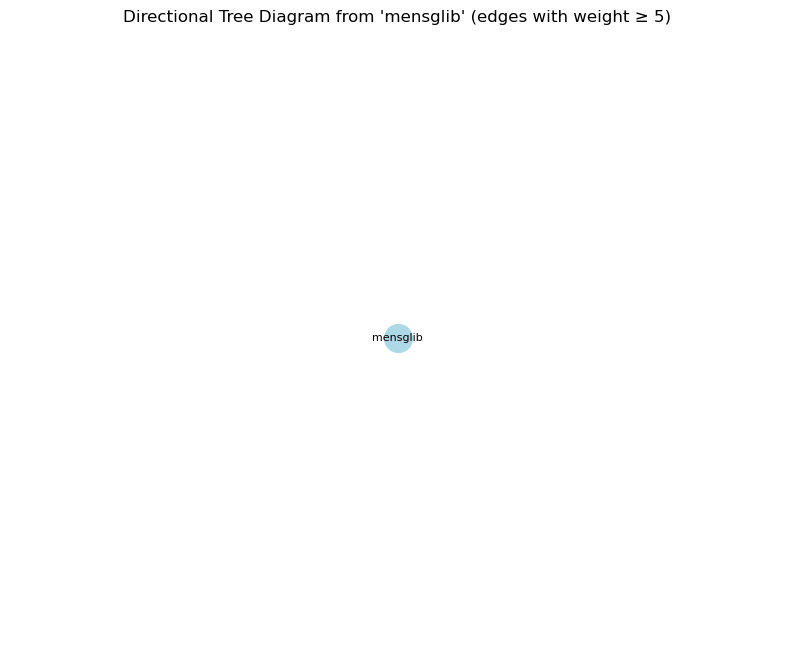

In [24]:
import networkx as nx
import matplotlib.pyplot as plt
import random

def visualize_directional_tree(G, root=None, max_nodes=30, weight_threshold=5):
    """
    Visualize a directed tree (BFS) from G, showing only edges above a weight threshold.
    Arrows indicate direction, and nodes are labeled.
    """
    # Choose a root if not provided
    if root is None:
        root = random.choice(list(G.nodes))
    # Build a BFS tree from the root
    tree = nx.bfs_tree(G, root)
    # Filter to only keep edges above the weight threshold
    filtered_tree = nx.DiGraph()
    filtered_tree.add_node(root)
    count = 1
    for u, v in tree.edges():
        if G.has_edge(u, v) and G[u][v].get('weight', 1) >= weight_threshold:
            filtered_tree.add_edge(u, v, weight=G[u][v]['weight'])
            filtered_tree.add_node(v)
            count += 1
            if count >= max_nodes:
                break
    # Draw the tree
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(filtered_tree, seed=42)
    nx.draw_networkx_nodes(filtered_tree, pos, node_color='lightblue', node_size=400)
    nx.draw_networkx_labels(filtered_tree, pos, font_size=8)
    nx.draw_networkx_edges(filtered_tree, pos, edge_color='gray', arrows=True, arrowsize=20, width=2, alpha=0.7)
    plt.title(f"Directional Tree Diagram from '{root}' (edges with weight ≥ {weight_threshold})")
    plt.axis('off')
    plt.show()

# Example usage:
visualize_directional_tree(G, root=None, max_nodes=30, weight_threshold=5)


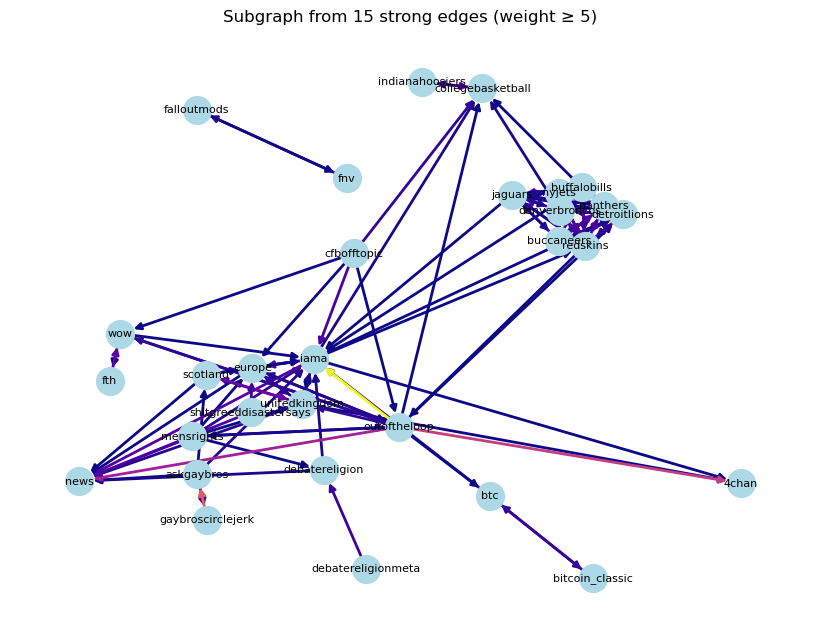

In [64]:
def visualize_weighted_subgraph_by_edges(G, edge_sample_size=30, weight_threshold=5):
    # Sample edges above threshold
    strong_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('weight', 1) >= weight_threshold]
    if not strong_edges:
        print("No edges above threshold.")
        return
    sampled_edges = random.sample(strong_edges, min(edge_sample_size, len(strong_edges)))
    nodes = set([u for u, v in sampled_edges] + [v for u, v in sampled_edges])
    subG = G.subgraph(nodes)
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(subG, seed=42, k=0.9)
    # Draw all edges, color by weight
    weights = [subG[u][v]['weight'] for u, v in subG.edges()]
    nx.draw(subG, pos, node_color='lightblue',
        node_size=400, edge_color=weights, width=2.0, edge_cmap=plt.cm.plasma)
    nx.draw_networkx_labels(subG, pos, font_size=8)  # Smaller font size

    plt.title(f"Subgraph from {len(sampled_edges)} strong edges (weight ≥ {weight_threshold})")
    plt.axis('off')
    plt.show()

# Usage:
visualize_weighted_subgraph_by_edges(G, edge_sample_size=15, weight_threshold=5)


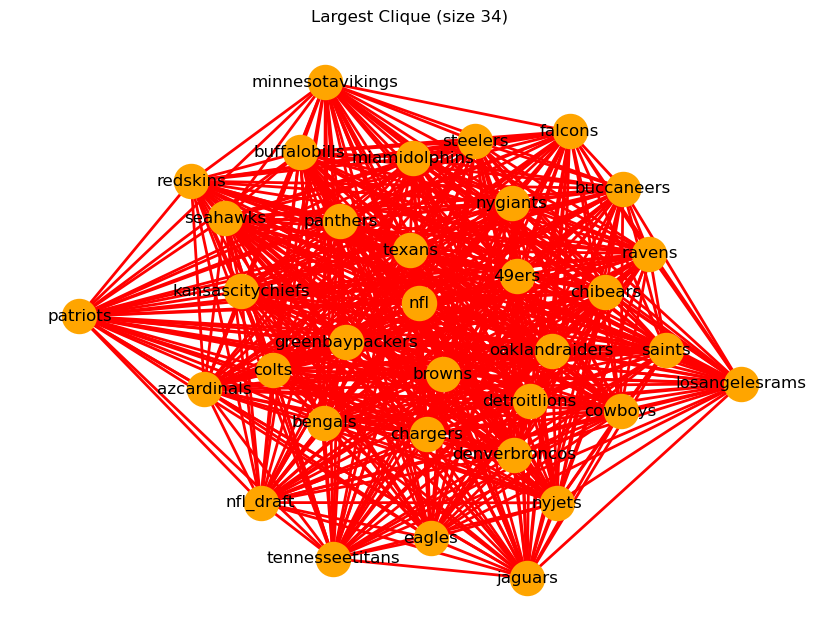

In [28]:
def visualize_global_largest_clique(G, min_size=3):
    G_undirected = G.to_undirected()
    cliques = list(nx.find_cliques(G_undirected))
    largest = max([c for c in cliques if len(c) >= min_size], key=len, default=[])
    if not largest:
        print("No clique found.")
        return
    subG = G_undirected.subgraph(largest)
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(subG, seed=42)
    nx.draw(subG, pos, with_labels=True, node_color='orange', node_size=600, edge_color='red', width=2)
    plt.title(f"Largest Clique (size {len(largest)})")
    plt.axis('off')
    plt.show()

visualize_global_largest_clique(G, min_size=4)


In [ ]:
def visualize_weighted_subgraph_by_edges(G, edge_sample_size=30, weight_threshold=5, layout='kamada_kawai'):
    # Sample strong edges
    strong_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('weight', 1) >= weight_threshold]
    if not strong_edges:
        print("No edges above threshold.")
        return
    sampled_edges = random.sample(strong_edges, min(edge_sample_size, len(strong_edges)))
    nodes = set([u for u, v in sampled_edges] + [v for u, v in sampled_edges])
    subG = G.subgraph(nodes)
    filteredG = nx.Graph()
    filteredG.add_nodes_from(subG.nodes)
    for u, v in sampled_edges:
        filteredG.add_edge(u, v, weight=G[u][v]['weight'])
    # Choose layout
    if layout == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(filteredG)
    elif layout == 'circular':
        pos = nx.circular_layout(filteredG)
    elif layout == 'shell':
        pos = nx.shell_layout(filteredG)
    else:
        pos = nx.spring_layout(filteredG, seed=42)
    # Draw
    plt.figure(figsize=(10, 8))
    edges = filteredG.edges()
    weights = [filteredG[u][v]['weight'] for u, v in edges]
    nx.draw_networkx_nodes(filteredG, pos, node_color='lightblue', node_size=600)
    nx.draw_networkx_labels(filteredG, pos, font_size=10)
    nx.draw_networkx_edges(filteredG, pos, edgelist=edges, width=[w/5 for w in weights], edge_color=weights, edge_cmap=plt.cm.plasma)
    plt.title(f"Subgraph from {len(sampled_edges)} strong edges (weight ≥ {weight_threshold})")
    plt.axis('off')
    plt.show()


C:\Users\rynoc\AppData\Local\Temp\ipykernel_32972\2751126039.py:29: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(filteredG, pos, edgelist=edges, width=[w/5 for w in weights], edge_color=weights, edge_cmap=plt.cm.plasma)


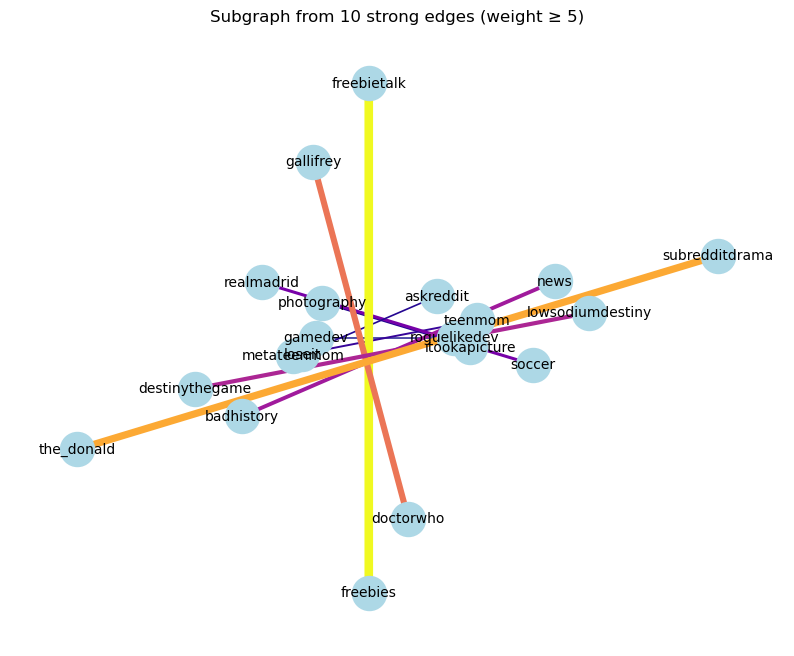

In [32]:
visualize_weighted_subgraph_by_edges(G, edge_sample_size=10, weight_threshold=5, layout='kamada_kawai')


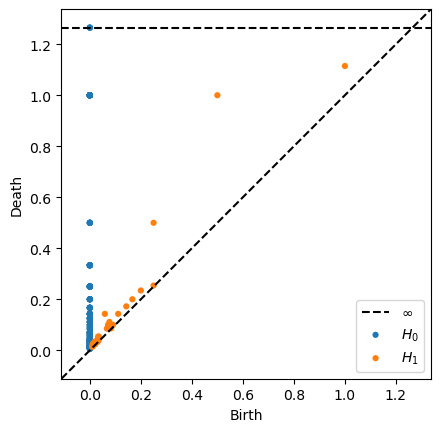

In [65]:
plot_diagrams(diagrams, show=True)


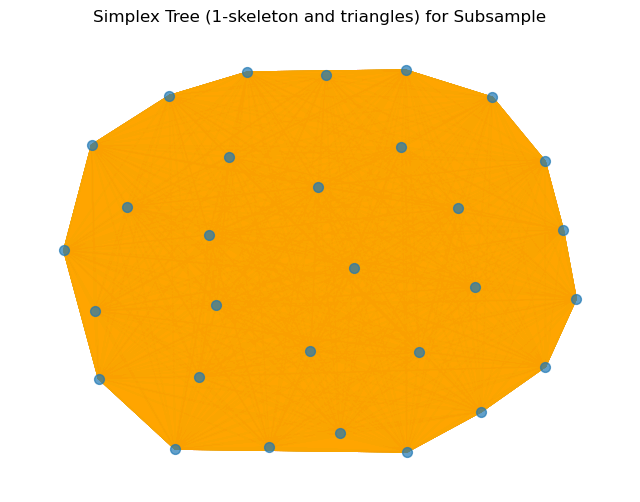

In [66]:
visualize_simplices(G, sample_size=30)
# or
#visualize_simplex_tree_with_threshold(G, sample_size=30, weight_threshold=5)


In [72]:
top_cliques_by_strength(G, top_n=10, min_size=3)


Top 10 cliques by average edge weight:
1. Size: 3, Strength: 122.67, Subreddits: ['circloljerk', 'leagueoflegends', 'summonerschool']
2. Size: 3, Strength: 84.33, Subreddits: ['gameshare', 'mushroomkingdom', 'gamesale']
3. Size: 3, Strength: 83.00, Subreddits: ['circloljerk', 'leagueoflegends', 'clg']
4. Size: 3, Strength: 82.67, Subreddits: ['wttnvidia', 'gamesale', 'mushroomkingdom']
5. Size: 3, Strength: 82.00, Subreddits: ['boardgameexchange', 'mushroomkingdom', 'gamesale']
6. Size: 3, Strength: 81.67, Subreddits: ['joahfx', 'gamesale', 'mushroomkingdom']
7. Size: 3, Strength: 81.67, Subreddits: ['yardsale', 'gamesale', 'mushroomkingdom']
8. Size: 3, Strength: 79.00, Subreddits: ['lux', 'summonerschool', 'leagueoflegends']
9. Size: 3, Strength: 78.33, Subreddits: ['summonerschool', 'leagueoflegends', 'kindred']
10. Size: 3, Strength: 77.33, Subreddits: ['summonerschool', 'leagueoflegends', 'jhinmains']


In [73]:
def plot_top_clique_strengths(G, top_n=10, min_size=3):
    G_undirected = G.to_undirected()
    cliques = list(nx.find_cliques(G_undirected))
    clique_strengths = []
    for clique in cliques:
        if len(clique) >= min_size:
            strength = clique_strength(clique, G_undirected)
            clique_strengths.append((' / '.join(clique), strength))
    top = sorted(clique_strengths, key=lambda x: x[1], reverse=True)[:top_n]
    names, strengths = zip(*top)
    plt.figure(figsize=(10, 4))
    plt.barh(names, strengths)
    plt.xlabel('Average Edge Weight')
    plt.title('Top Cliques by Strength')
    plt.tight_layout()
    plt.show()


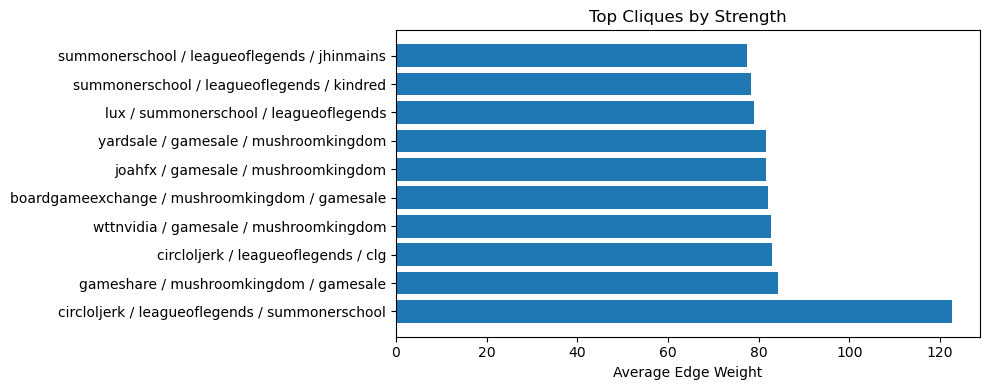

In [74]:
plot_top_clique_strengths(G, top_n=10, min_size=3)


In [75]:
def plot_top_insulated_cliques(G, top_n=10, min_size=3, max_size=5):
    G_undirected = G.to_undirected()
    cliques = [c for c in nx.find_cliques(G_undirected) if min_size <= len(c) <= max_size]
    results = []
    for clique in cliques:
        in_count = sum(len([src for src in G.predecessors(node) if src not in clique]) for node in clique)
        out_count = sum(len([tgt for tgt in G.successors(node) if tgt not in clique]) for node in clique)
        results.append((' / '.join(clique), in_count, out_count))
    # Sort by fewest incoming, then outgoing
    results = sorted(results, key=lambda x: (x[1], x[2]))[:top_n]
    names = [r[0] for r in results]
    in_counts = [r[1] for r in results]
    out_counts = [r[2] for r in results]
    x = np.arange(len(names))
    plt.figure(figsize=(12, 4))
    plt.bar(x-0.15, in_counts, width=0.3, label='Incoming')
    plt.bar(x+0.15, out_counts, width=0.3, label='Outgoing')
    plt.xticks(x, names, rotation=45, ha='right', fontsize=8)
    plt.ylabel('Edges')
    plt.title('Top Insulated Cliques (Fewest Incoming/Outgoing Edges)')
    plt.legend()
    plt.tight_layout()
    plt.show()


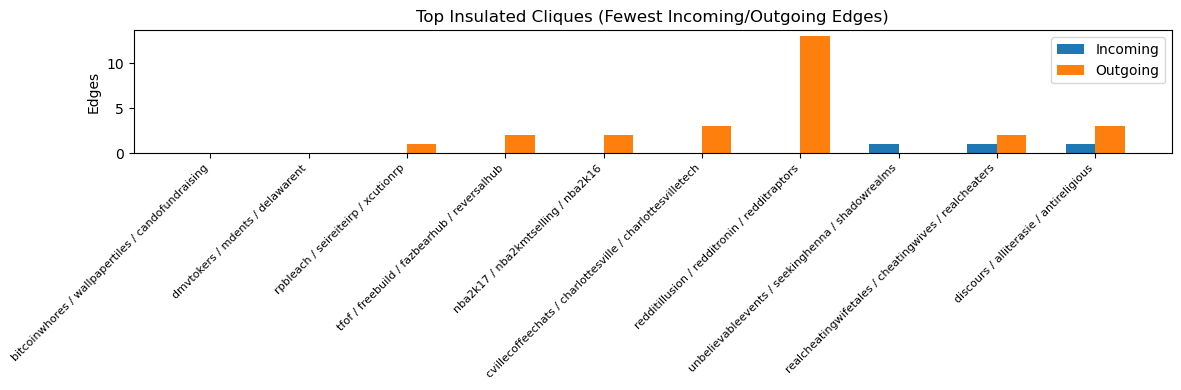

In [76]:
plot_top_insulated_cliques(G, top_n=10, min_size=3, max_size=5)


Nodes (subreddits) in a representative cycle for the most persistent H1 feature:
['greenlattice', 'placenostalgia', 'place']


C:\Users\rynoc\AppData\Local\Temp\ipykernel_32972\1127458669.py:26: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G_thresh, pos, edgelist=cycle_edges, edge_color='red', width=3)


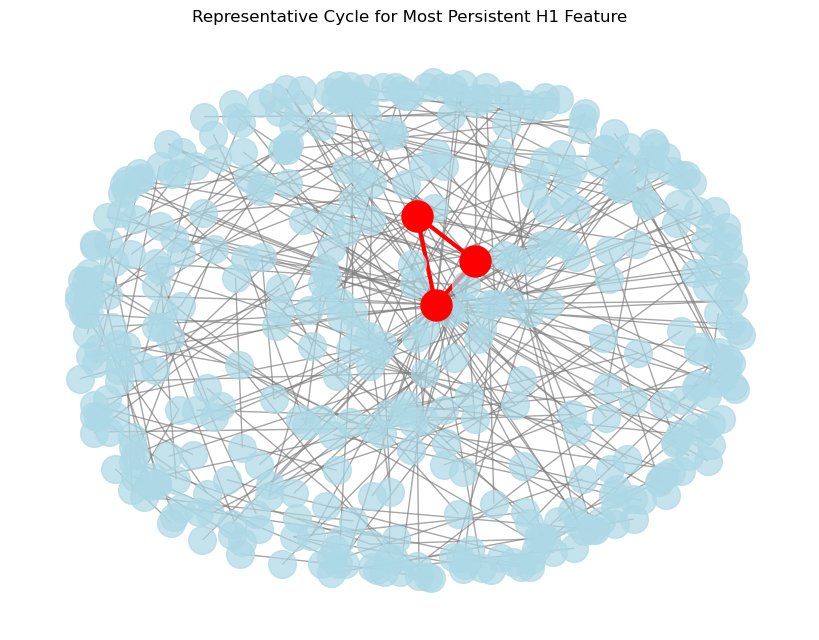

In [95]:
def visualize_representative_cycle(distance_matrix, nodes, diagrams):
    import matplotlib.pyplot as plt
    import networkx as nx
    H1 = diagrams[1]
    persistences = H1[:,1] - H1[:,0]
    most_persistent_idx = np.argmax(persistences)
    birth_value = H1[most_persistent_idx, 0]
    threshold = birth_value + 1e-8
    adjacency = (distance_matrix <= threshold).astype(int)
    G_thresh = nx.Graph()
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if adjacency[i, j]:
                G_thresh.add_edge(nodes[i], nodes[j])
    cycles = nx.cycle_basis(G_thresh)
    if cycles:
        cycle = cycles[0]
        print("Nodes (subreddits) in a representative cycle for the most persistent H1 feature:")
        print(cycle)
        # Visualization
        plt.figure(figsize=(8, 6))
        pos = nx.spring_layout(G_thresh, seed=42, k=0.5)
        nx.draw(G_thresh, pos, node_color='lightblue', with_labels=False, node_size=400, edge_color='gray', alpha=0.7)
        # Highlight the cycle
        cycle_edges = [(cycle[i], cycle[(i+1)%len(cycle)]) for i in range(len(cycle))]
        nx.draw_networkx_edges(G_thresh, pos, edgelist=cycle_edges, edge_color='red', width=3)
        nx.draw_networkx_nodes(G_thresh, pos, nodelist=cycle, node_color='red', node_size=500)
        plt.title("Representative Cycle for Most Persistent H1 Feature")
        plt.axis('off')
        plt.show()
    else:
        print("No cycles found at this threshold.")

# Usage:
visualize_representative_cycle(distance_matrix, nodes, diagrams)


C:\Users\rynoc\AppData\Local\Temp\ipykernel_32972\3012478354.py:34: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(top_subG, pos, edge_color='red', width=2)


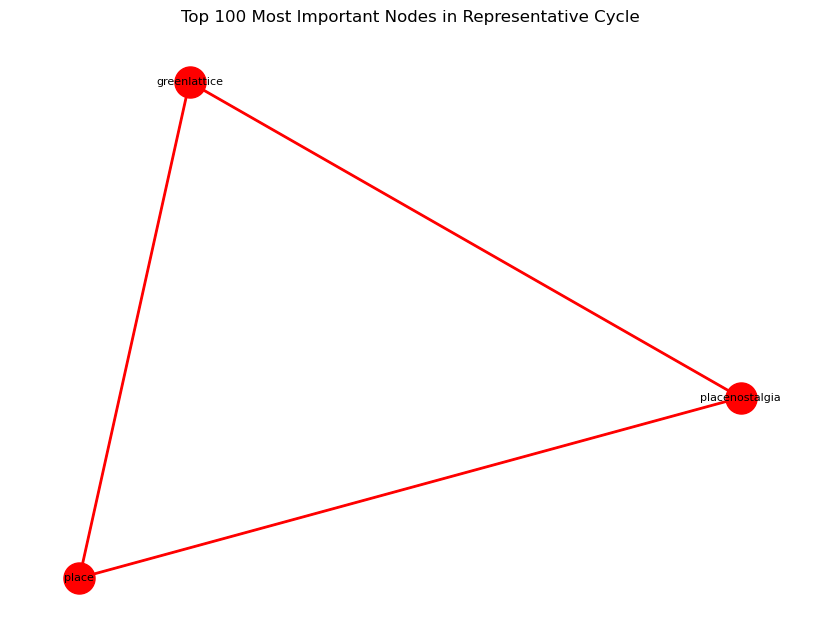

Top nodes in the representative cycle (by degree):
greenlattice (degree 2)
placenostalgia (degree 2)
place (degree 2)


In [101]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def visualize_representative_cycle_subsample(distance_matrix, nodes, diagrams, top_n=8):
    H1 = diagrams[1]
    persistences = H1[:,1] - H1[:,0]
    most_persistent_idx = np.argmax(persistences)
    birth_value = H1[most_persistent_idx, 0]
    threshold = birth_value + 1e-8
    adjacency = (distance_matrix <= threshold).astype(int)
    G_thresh = nx.Graph()
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if adjacency[i, j]:
                G_thresh.add_edge(nodes[i], nodes[j])
    cycles = nx.cycle_basis(G_thresh)
    if not cycles:
        print("No cycles found at this threshold.")
        return
    cycle = cycles[0]
    # Build subgraph of the cycle
    cycle_subG = G_thresh.subgraph(cycle)
    # Rank nodes by degree within the cycle
    degrees = dict(cycle_subG.degree())
    # Get top_n nodes by degree
    top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:top_n]
    # Induced subgraph on top nodes
    top_subG = cycle_subG.subgraph(top_nodes)
    # Visualization
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(top_subG, seed=42)
    nx.draw(top_subG, pos, node_color='red', node_size=500, with_labels=True, font_size=8)
    nx.draw_networkx_edges(top_subG, pos, edge_color='red', width=2)
    plt.title(f"Top {top_n} Most Important Nodes in Representative Cycle")
    plt.axis('off')
    plt.show()
    print("Top nodes in the representative cycle (by degree):")
    for n in top_nodes:
        print(f"{n} (degree {degrees[n]})")

# Usage:
visualize_representative_cycle_subsample(distance_matrix, nodes, diagrams, top_n=100)


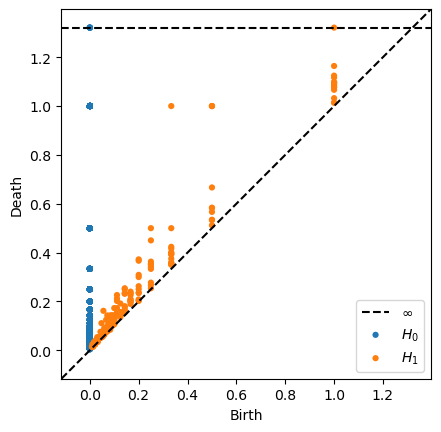

In [114]:
#take last 1000 nodes for a larger subgraph
nodes = list(G.nodes)[:1000]
subG = G.subgraph(nodes)
distance_matrix = compute_distance_matrix(subG, nodes)
diagrams = ripser(distance_matrix, distance_matrix=True)['dgms']
plot_diagrams(diagrams, show=True)

C:\Users\rynoc\AppData\Local\Temp\ipykernel_32972\3012478354.py:34: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(top_subG, pos, edge_color='red', width=2)


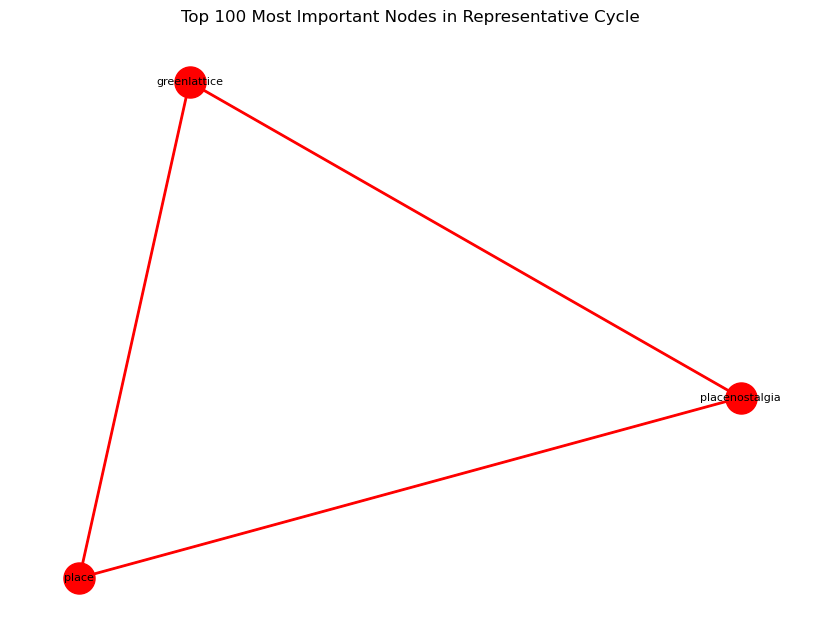

Top nodes in the representative cycle (by degree):
greenlattice (degree 2)
placenostalgia (degree 2)
place (degree 2)


In [103]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def visualize_representative_cycle_subsample(distance_matrix, nodes, diagrams, top_n=8):
    H1 = diagrams[1]
    persistences = H1[:,1] - H1[:,0]
    most_persistent_idx = np.argmax(persistences)
    birth_value = H1[most_persistent_idx, 0]
    threshold = birth_value + 1e-8
    adjacency = (distance_matrix <= threshold).astype(int)
    G_thresh = nx.Graph()
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if adjacency[i, j]:
                G_thresh.add_edge(nodes[i], nodes[j])
    cycles = nx.cycle_basis(G_thresh)
    if not cycles:
        print("No cycles found at this threshold.")
        return
    cycle = cycles[0]
    # Build subgraph of the cycle
    cycle_subG = G_thresh.subgraph(cycle)
    # Rank nodes by degree within the cycle
    degrees = dict(cycle_subG.degree())
    # Get top_n nodes by degree
    top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:top_n]
    # Induced subgraph on top nodes
    top_subG = cycle_subG.subgraph(top_nodes)
    # Visualization
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(top_subG, seed=42)
    nx.draw(top_subG, pos, node_color='red', node_size=500, with_labels=True, font_size=8)
    nx.draw_networkx_edges(top_subG, pos, edge_color='red', width=2)
    plt.title(f"Top {top_n} Most Important Nodes in Representative Cycle")
    plt.axis('off')
    plt.show()
    print("Top nodes in the representative cycle (by degree):")
    for n in top_nodes:
        print(f"{n} (degree {degrees[n]})")

# Usage:
visualize_representative_cycle_subsample(distance_matrix, nodes, diagrams, top_n=100)


Nodes (subreddits) in a representative cycle for the most persistent H1 feature:
['greenlattice', 'placenostalgia', 'place']


C:\Users\rynoc\AppData\Local\Temp\ipykernel_32972\1127458669.py:26: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G_thresh, pos, edgelist=cycle_edges, edge_color='red', width=3)


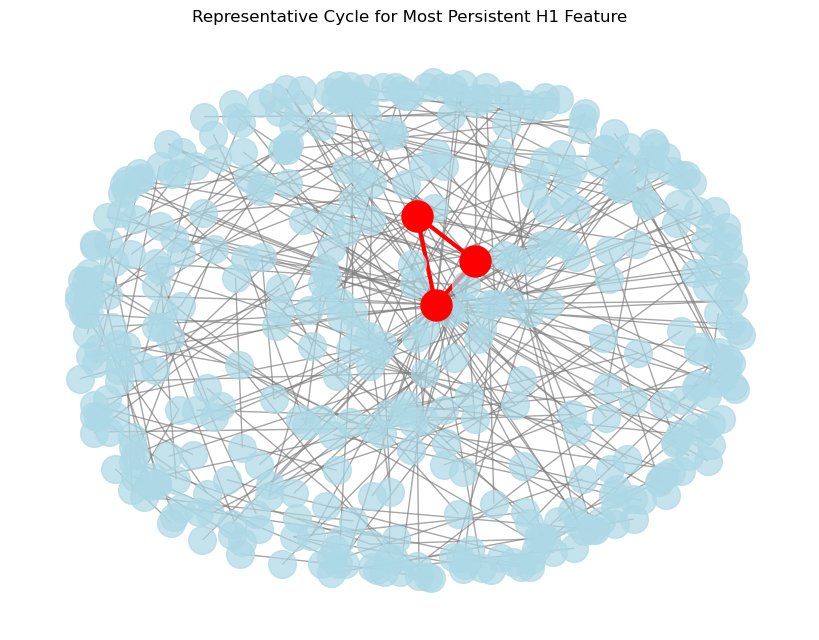

In [104]:
visualize_representative_cycle(distance_matrix, nodes, diagrams)

In [110]:
def get_representative_cycle(distance_matrix, nodes, diagrams):
    H1 = diagrams[1]
    persistences = H1[:,1] - H1[:,0]
    most_persistent_idx = np.argmax(persistences)
    birth_value = H1[most_persistent_idx, 0]
    threshold = birth_value + 1e-8
    adjacency = (distance_matrix <= threshold).astype(int)
    G_thresh = nx.Graph()
    for i in range(len(nodes)):
        for j in range(i+1, len(nodes)):
            if adjacency[i, j]:
                G_thresh.add_edge(nodes[i], nodes[j])
    cycles = nx.cycle_basis(G_thresh)
    if cycles:
        print("Nodes (subreddits) in a representative cycle for the most persistent H1 feature:")
        print(cycles[0])
        return cycles[0]  # <-- Return the representative cycle as a list
    else:
        print("No cycles found at this threshold.")
        return None

# Usage:
representative_cycle = get_representative_cycle(distance_matrix, nodes, diagrams)
if representative_cycle is not None:
    print("Representative cycle nodes:", representative_cycle)


Nodes (subreddits) in a representative cycle for the most persistent H1 feature:
['leagueoflegends', 'pornfree', 'dogecoin']
Representative cycle nodes: ['leagueoflegends', 'pornfree', 'dogecoin']
